In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame, Series
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
# import sampler as sp

In [2]:
train_stat = pd.read_csv('./sep_data/train_scaled_stat_feat_df.csv')
dev_stat = pd.read_csv('./sep_data/dev_scaled_stat_feat_df.csv')

train_tweet = pd.read_csv('./sep_data/train_tweet_df.csv')
dev_tweet = pd.read_csv('./sep_data/dev_tweet_df.csv')

# train_stat.info()

# dev_stat.info()

train_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
train_stat.head()

dev_stat.drop(columns=['Unnamed: 0','label'], inplace=True)
dev_stat.head()

train_stat.sum()

dev_zero = []
for column in dev_stat.columns:
    if dev_stat[column].sum() == 0:
        dev_zero.append(column)
print(dev_zero)

train_zero = []
for column in train_stat.columns:
    if train_stat[column].sum() == 0:
        train_zero.append(column)
print(train_zero)

train_stat.drop(columns=train_zero, inplace=True)
dev_stat.drop(columns=dev_zero, inplace=True)

dev_tweet.head()

['reply_contributors', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']
['reply_contributors', 'reply_possibly_sensitive_appealable', 'reply_favorited', 'reply_retweeted', 'reply_protected', 'reply_contributors_enabled', 'reply_is_translator', 'reply_following', 'reply_follow_request_sent', 'reply_notifications', 'possibly_sensitive_appealable', 'favorited', 'retweeted', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications']


,tweet_id,text,reply_text,label
0,1240727985491193862,covid viru transmit area hot humid world healt...,humid good demonstr virus surviv temperatur hi...,0
1,634943791934406657,marilyn monro jame dean smoke new york citi http,icon [SEP] http [SEP] yo puedo demostrar que e...,1
2,1243967693297987584,symptom covid jcinigeria,symptom usual mild gradual common [SEP] infect...,0
3,1233175449980874752,coronaviru wear mask protect covid,thank [SEP],0
4,1245592346344841216,symptom covid let watch new episod q covid know,infect peopl around world believ togeth stop [...,0


### Fill NaN

In [3]:
# dev_tweet.info()

# train_tweet.info()

dev_tweet.reply_text.fillna('', inplace=True)
train_tweet.reply_text.fillna('', inplace=True)
dev_tweet.text.fillna('', inplace=True)
train_tweet.text.fillna('', inplace=True)

dev_tweet.info()

# dev_tweet.iloc[0].reply_text

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    536 non-null    int64 
 1   text        536 non-null    object
 2   reply_text  536 non-null    object
 3   label       536 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 16.9+ KB


### Get Embeddings

In [4]:
for i in tqdm(range(len(dev_tweet))):
    dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(dev_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

for i in tqdm(range(len(train_tweet))):
    train_tweet.text.iloc[i] = '[CLS] ' + str(train_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(train_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

dev_tweet.iloc[0].text

  0%|                                                                                          | 0/536 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_28584\2101879647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(dev_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
  0%|                                                                                         | 0/1579 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_28584\2101879647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tweet.text.iloc[i

'[CLS] covid viru transmit area hot humid world health organ [SEP] humid good demonstr virus surviv temperatur high [SEP] mean warm weather good elimin [SEP]'

In [5]:
from transformers import BertModel
# bert_model = BertModel.from_pretrained('bert-base-uncased')

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### BERT Embeddings

In [139]:
max_len = 256
dev_tokens = []
train_tokens = []

for i in tqdm(range(len(dev_tweet))):
    txt = dev_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    token_ids_t = torch.tensor(token_ids).unsqueeze(0) #Shape : [1, 12]
    attn_mask_t = torch.tensor(attn_mask).unsqueeze(0) #Shape : [1, 12]
    seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0) #Shape : [1, 12]
    outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
                                  token_type_ids = seg_ids_t, return_dict=True)
    cont_reps = outputs.last_hidden_state
    cls_rep = cont_reps[:, 0]
    dev_tokens.append(cls_rep.detach().numpy())

for i in tqdm(range(len(train_tweet))):
    txt = train_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    token_ids_t = torch.tensor(token_ids).unsqueeze(0)
    attn_mask_t = torch.tensor(attn_mask).unsqueeze(0)
    seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0)
    outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
                                  token_type_ids = seg_ids_t, return_dict=True)
    cont_reps = outputs.last_hidden_state
    cls_rep = cont_reps[:, 0]
    train_tokens.append(cls_rep.detach().numpy())

  3%|██▋                                                                              | 18/536 [00:07<03:44,  2.31it/s]


KeyboardInterrupt: 

### BERT seq

In [6]:
max_len = 256
dev_seq = []
train_seq = []
dev_mask = []
train_mask = []
dev_seg = []
train_seg = []

for i in tqdm(range(len(dev_tweet))):
    txt = dev_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    # seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    dev_seq.append(token_ids)
    dev_mask.append(attn_mask)
    dev_seg.append(seg_ids)

for i in tqdm(range(len(train_tweet))):
    txt = train_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = []
    seg_idx = 0
    for token in padded_tokens:
        seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    train_seq.append(token_ids)
    train_mask.append(attn_mask)
    train_seg.append(seg_ids)

100%|█████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:04<00:00, 332.47it/s]


### test BERT adjustment

In [7]:
class AdTweetDataset(Data.Dataset):
    def __init__(self, seq_, mask_, seg_, y_):
        self.seq = torch.tensor(seq_)
        self.mask = torch.tensor(mask_)
        self.seg = torch.tensor(seg_)
        self.y = torch.tensor(y_)
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.y[idx], idx

In [8]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']
w_nonr = len(y_train)/(len(y_train)-y_train.sum())
w_r = len(y_train)/(y_train.sum())
weights = []
for l in y_train:
    if l == 0:
        weights.append(w_nonr)
    else:
        weights.append(w_r)
weights = torch.FloatTensor(weights)

In [19]:
torch.manual_seed(42)
train_set = AdTweetDataset(train_seq, train_mask, train_seg,y_train)
dev_set = AdTweetDataset(dev_seq, dev_mask, dev_seg, y_dev)

# sampler_s = sp.StratifiedSampler(class_vector=torch.from_numpy(np.array(y_train)), batch_size=64)
train_sampler = Data.WeightedRandomSampler(weights, len(train_set), replacement=True)
train_loader = Data.DataLoader(train_set, sampler=train_sampler,batch_size=64)
# train_loader = Data.DataLoader(train_set,batch_size=64,shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=64, shuffle=False)

In [15]:
class RumorClassifier(nn.Module):

    def __init__(self):
        super(RumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(811,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, seq_,attn_masks, seg_, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq_, attention_mask = attn_masks,token_type_ids = seg_, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(x)

        return logits

In [20]:
# torch.cuda.empty_cache ()
net = RumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
def get_accuracy_from_logits(logits, labels):
    probs = logits.unsqueeze(-1)
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def get_f1_from_logits(logits, labels):
    preds = (logits > 0.5).astype(int)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, pos_label=1, average="binary")
    return f

def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    all_log = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for seq, mask, seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            stats = np.array(train_stat)
            stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(seq, mask, seg, stats)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            # mean_acc += get_accuracy_from_logits(logits, labels)
            
            all_log = np.hstack((all_log, logits.squeeze()))
            all_labels = np.hstack((all_labels, labels.numpy()))
            count += 1
        
        f = get_f1_from_logits(all_log, all_labels)
    return f, mean_loss / count

In [21]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

In [22]:
for ep in range(20):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development F1: {}; Development Loss: {}".format(dev_acc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.6907795071601868; Accuracy: 0.546875; Time taken (s): 37.0798876285553
Iteration 10 of epoch 0 complete. 
 Loss: 0.6650289297103882; Accuracy: 0.78125; Time taken (s): 366.09376072883606
Iteration 20 of epoch 0 complete. 
 Loss: 0.6258490681648254; Accuracy: 0.75; Time taken (s): 364.69323897361755
Development F1: 0.5406976744186047; Development Loss: 0.5908371806144714
Iteration 0 of epoch 1 complete. 
 Loss: 0.5946479439735413; Accuracy: 0.75; Time taken (s): 414.4184765815735
Iteration 10 of epoch 1 complete. 
 Loss: 0.5516828894615173; Accuracy: 0.765625; Time taken (s): 398.88207840919495
Iteration 20 of epoch 1 complete. 
 Loss: 0.5077426433563232; Accuracy: 0.8125; Time taken (s): 367.97492384910583
Development F1: 0.5733788395904437; Development Loss: 0.5149298906326294
Iteration 0 of epoch 2 complete. 
 Loss: 0.43578824400901794; Accuracy: 0.875; Time taken (s): 285.096022605896
Iteration 10 of epoch 2 complete. 
 Loss: 0.383047074079

In [31]:
for ep in range(20,40):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)
        
        stats = np.array(train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, dev_loss = evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development F1: {}; Development Loss: {}".format(dev_acc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 20 complete. 
 Loss: 0.019885603338479996; Accuracy: 1.0; Time taken (s): 246.2210726737976
Iteration 10 of epoch 20 complete. 
 Loss: 0.015068178065121174; Accuracy: 1.0; Time taken (s): 364.4286153316498
Iteration 20 of epoch 20 complete. 
 Loss: 0.014043761417269707; Accuracy: 1.0; Time taken (s): 456.5346965789795
Development F1: 0.8034934497816594; Development Loss: 0.32976017230086857
Iteration 0 of epoch 21 complete. 
 Loss: 0.02222348563373089; Accuracy: 1.0; Time taken (s): 248.7010898590088
Iteration 10 of epoch 21 complete. 
 Loss: 0.020274026319384575; Accuracy: 1.0; Time taken (s): 303.29566860198975
Iteration 20 of epoch 21 complete. 
 Loss: 0.015691112726926804; Accuracy: 1.0; Time taken (s): 309.9355397224426
Development F1: 0.8127853881278538; Development Loss: 0.2758317864499986
Iteration 0 of epoch 22 complete. 
 Loss: 0.08303241431713104; Accuracy: 0.984375; Time taken (s): 304.21868419647217
Iteration 10 of epoch 22 complete. 
 Loss: 0.01541355

### Optimize Embedding

In [23]:
class RumorEmbedder(nn.Module):

    def __init__(self):
        super(RumorEmbedder, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(811,512),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(512,256)
                                 )

    def forward(self, seq, attn_masks, seg, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks,token_type_ids=seg, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        embs = self.ffnn(x)

        return embs

In [24]:
def cos_sim(a,b):
    norm_a = torch.norm(a, dim=1)
    norm_b = torch.norm(b, dim=0)
    return torch.mm(a,b)/torch.mm(norm_a.unsqueeze(1), norm_b.unsqueeze(0))

class IntraInterLoss(nn.Module):

    def __init__(self):
        super(IntraInterLoss, self).__init__()

    def forward(self, emb, target):
        nr_emb = emb[target==0]
        r_emb = emb[target==1]
        count_1_1 = r_emb.shape[0]**2
        count_0_0 = nr_emb.shape[0]**2
        count_0_1 = r_emb.shape[0]*nr_emb.shape[0]
        r_cos = torch.sum(cos_sim(r_emb, r_emb.T))/float(count_1_1)
        nr_cos = torch.sum(cos_sim(nr_emb, nr_emb.T))/float(count_0_0)
        r_nr_cos = torch.sum(cos_sim(r_emb, nr_emb.T))/float(count_0_1)
        
        return r_nr_cos-0.4*r_cos-0.2*nr_cos

In [25]:
from torch.optim import lr_scheduler
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False)
# torch.cuda.empty_cache ()
net = RumorEmbedder()
# net = net.to(device)

criterion = IntraInterLoss()
opti = optim.Adam(net.parameters(), lr = 0.001)
scheduler = lr_scheduler.ExponentialLR(opti, gamma=0.7)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
import time
st = time.time()
for ep in range(20):
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        stats = np.array(train_stat)
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        #Computing loss
        loss = criterion(logits, labels)

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            print("Iteration {} of epoch {} complete. \n Loss: {}; Time taken (s): {}".format(it, ep, loss.item(), (time.time()-st)))
            st = time.time()

    net.eval()
    with torch.no_grad():
        for seq, mask, seg, labels, idx in dev_loader:
            dev_embs = net(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))
        dev_loss = criterion(dev_embs, labels)
    
    print("Development Loss: {}".format(dev_loss.item()))
    torch.save(net.state_dict(), 'D:\\bertemb_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.21107256412506104; Time taken (s): 36.5722496509552
Iteration 10 of epoch 0 complete. 
 Loss: 0.00258546881377697; Time taken (s): 370.3924024105072
Iteration 20 of epoch 0 complete. 
 Loss: -0.2281695157289505; Time taken (s): 371.6792678833008
Development Loss: -0.33488768339157104
Iteration 0 of epoch 1 complete. 
 Loss: -0.2677144408226013; Time taken (s): 286.99082374572754
Iteration 10 of epoch 1 complete. 
 Loss: -0.5775624513626099; Time taken (s): 367.949254989624
Iteration 20 of epoch 1 complete. 
 Loss: -0.1781993955373764; Time taken (s): 368.10459208488464
Development Loss: -0.36340734362602234
Iteration 0 of epoch 2 complete. 
 Loss: -0.5245465040206909; Time taken (s): 280.88317370414734
Iteration 10 of epoch 2 complete. 
 Loss: -0.2928198575973511; Time taken (s): 366.15686988830566
Iteration 20 of epoch 2 complete. 
 Loss: -0.3540284335613251; Time taken (s): 367.9296464920044
Development Loss: -0.40007686614990234
Iteration 0

KeyboardInterrupt: 

### BertEmbedding Test

In [53]:
net = RumorEmbedder()
net.load_state_dict(torch.load('D:\\bertemb_9.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [99]:
dev_loader = Data.DataLoader(dev_set, batch_size=len(dev_set), shuffle=False,sampler=range(0,len(dev_set)))
train_loader = Data.DataLoader(train_set, batch_size=len(train_set), shuffle=False, sampler=range(0,len(train_set)))

In [100]:
net.eval()
with torch.no_grad():
    for seq, mask, seg, labels,idx in train_loader:
        train_embs = net(seq, mask, seg, torch.FloatTensor(np.array(train_stat)))
    for seq, mask, seg, labels, idx in dev_loader:
        dev_embs = net(seq, mask, seg, torch.FloatTensor(np.array(dev_stat)))

In [102]:
r_mean = train_embs[np.array(y_train) == 1].mean(dim=0).numpy()
nr_mean = train_embs[np.array(y_train) == 0].mean(dim=0).numpy()
dev_embs_n = dev_embs.numpy()
dev_preds = []

for emb in dev_embs_n:
    r_sim = np.dot(emb, r_mean)/(np.linalg.norm(emb)*np.linalg.norm(r_mean))
    nr_sim = np.dot(emb, nr_mean)/(np.linalg.norm(emb)*np.linalg.norm(nr_mean))
    if r_sim >= nr_sim:
        dev_preds.append(1)
    else:
        dev_preds.append(0)

p, r, f, _ = precision_recall_fscore_support(y_dev, dev_preds, pos_label=1, average="binary")
print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))
print('Accuracy: {}'.format(accuracy_score(y_dev, dev_preds)))

Precision:0.35964912280701755  Recall:0.7130434782608696  F1:0.47813411078717205
Accuracy: 0.6660447761194029


In [103]:
r_mean = train_embs[np.array(y_train) == 1].mean(dim=0).numpy()
nr_mean = train_embs[np.array(y_train) == 0].mean(dim=0).numpy()
dev_embs_n = dev_embs.numpy()
dev_preds = []

for emb in train_embs.numpy():
    r_sim = np.dot(emb, r_mean)/(np.linalg.norm(emb)*np.linalg.norm(r_mean))
    nr_sim = np.dot(emb, nr_mean)/(np.linalg.norm(emb)*np.linalg.norm(nr_mean))
    if r_sim >= nr_sim:
        dev_preds.append(1)
    else:
        dev_preds.append(0)

p, r, f, _ = precision_recall_fscore_support(y_train, dev_preds, pos_label=1, average="binary")
print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))
print('Accuracy: {}'.format(accuracy_score(y_train, dev_preds)))

Precision:0.3890675241157556  Recall:0.7610062893081762  F1:0.5148936170212767
Accuracy: 0.7112096263457884


In [97]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embs.numpy(), y_train)

predictions = knn.predict(dev_embs_n)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.5463917525773195  Recall:0.4608695652173913  F1:0.5
Accuracy: 0.8022388059701493


In [107]:
import pickle
with open('X_train.pkl','rb') as file:
    X_train = pickle.load(file)
with open('X_dev.pkl','rb') as file:
    X_dev = pickle.load(file)
with open('y_dev.pkl','rb') as file:
    y_dev = pickle.load(file)
with open('y_train.pkl','rb') as file:
    y_train = pickle.load(file)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

predictions = knn.predict(X_dev)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.6732673267326733  Recall:0.6181818181818182  F1:0.6445497630331753
Accuracy: 0.8563218390804598


In [98]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
lr.fit(train_embs.numpy(), y_train)

predictions = lr.predict(dev_embs_n)

p, r, f, _ = precision_recall_fscore_support(y_dev, predictions, pos_label=1, average="binary")

print('Precision:{}  Recall:{}  F1:{}'.format(p,r,f))

print('Accuracy: {}'.format(accuracy_score(y_dev, predictions)))

Precision:0.6666666666666666  Recall:0.06956521739130435  F1:0.12598425196850394
Accuracy: 0.792910447761194


C:\Users\trist\anaconda3\envs\Pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
r_mean

array([ 0.559523  , -0.6694411 ,  0.6386693 , -0.3082815 , -1.4688318 ,
        1.0080024 ,  0.76538223,  1.5122892 , -0.85284615,  1.7891976 ,
       -1.4008505 , -0.55482763,  1.8608657 , -0.6717017 ,  0.97310126,
        0.5818697 , -0.5390343 , -0.7755241 ,  1.9045625 , -0.26476654,
       -1.3056165 , -0.9074661 ,  0.7634458 , -1.5461605 ,  0.08976556,
       -0.8494065 , -0.8777184 , -1.0230728 ,  0.3525765 , -1.5808235 ,
        0.01667575, -0.1495756 , -0.3053692 ,  0.07764101, -1.1683062 ,
        0.7895137 , -0.09378773, -0.17215891, -0.15668851,  0.42977983,
        0.4158164 , -1.5737258 ,  1.8172727 ,  1.4243525 ,  1.8285083 ,
        0.71199876, -0.9187279 ,  1.1941608 ,  0.565277  ,  0.28214428,
        1.4069462 ,  1.2998426 ,  1.0016237 , -0.82209605, -0.50618243,
        0.05480868,  1.6530193 , -0.52838504,  0.8456729 , -1.1414135 ,
       -0.13572106,  0.576234  ,  0.7270736 , -1.4084289 ], dtype=float32)

In [67]:
nr_mean

array([ 0.5737024 , -0.6759854 ,  0.6507191 , -0.32405192, -1.4975203 ,
        1.0036894 ,  0.78646857,  1.5012347 , -0.87575895,  1.8210517 ,
       -1.4066744 , -0.5509191 ,  1.885839  , -0.68972784,  0.9726847 ,
        0.5760501 , -0.54722756, -0.80475795,  1.9094418 , -0.26871154,
       -1.3065656 , -0.9108496 ,  0.78440595, -1.5575368 ,  0.07096983,
       -0.8725201 , -0.853683  , -1.0237498 ,  0.34915003, -1.5788484 ,
        0.02422947, -0.13966322, -0.32549387,  0.08283487, -1.1725831 ,
        0.7983685 , -0.07583883, -0.16052043, -0.15137553,  0.4250438 ,
        0.41498375, -1.5853176 ,  1.8458185 ,  1.4217794 ,  1.8454164 ,
        0.7082451 , -0.94747126,  1.2044528 ,  0.55465084,  0.29615617,
        1.405537  ,  1.2859378 ,  1.0131048 , -0.8556225 , -0.49518442,
        0.05648269,  1.654872  , -0.5226128 ,  0.84434843, -1.1529379 ,
       -0.14024371,  0.5695921 ,  0.74909246, -1.4219875 ], dtype=float32)

### Text Only Bert

In [18]:
class TextRumorClassifier(nn.Module):

    def __init__(self):
        super(TextRumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(768,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, seq, attn_masks, seg):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        # x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(cls_rep)

        return logits

In [35]:
net = TextRumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def text_evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, mask, seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            # stats = np.array(train_stat.iloc[:,1:])
            # stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(seq, mask, seg)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [27]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

In [36]:
for ep in range(20):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):

        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)

        # stats = np.array(train_stat.iloc[:,1:])
        # stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg)

        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()


    dev_acc, dev_loss = text_evaluate(net, criterion, dev_loader, 'cpu')
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development Accuracy: {}; Development Loss: {}".format(dev_acc, dev_loss))
    torch.save(net.state_dict(), 'D:\\bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.6802356839179993; Accuracy: 0.671875; Time taken (s): 81.13227605819702
Iteration 10 of epoch 0 complete. 
 Loss: 0.5898295044898987; Accuracy: 0.78125; Time taken (s): 299.43943309783936
Iteration 20 of epoch 0 complete. 
 Loss: 0.5761324763298035; Accuracy: 0.75; Time taken (s): 298.0222783088684
Development Accuracy: 0.7715277671813965; Development Loss: 0.5319444206025865
Iteration 0 of epoch 1 complete. 
 Loss: 0.5774604678153992; Accuracy: 0.734375; Time taken (s): 220.4582164287567
Iteration 10 of epoch 1 complete. 
 Loss: 0.4819682836532593; Accuracy: 0.8125; Time taken (s): 296.9613416194916
Iteration 20 of epoch 1 complete. 
 Loss: 0.45131972432136536; Accuracy: 0.796875; Time taken (s): 297.24166321754456
Development Accuracy: 0.7996528148651123; Development Loss: 0.43302328056759304
Iteration 0 of epoch 2 complete. 
 Loss: 0.4024360477924347; Accuracy: 0.8125; Time taken (s): 225.989727973938
Iteration 10 of epoch 2 complete. 
 Los

### Text Only Test

In [37]:
text_model = TextRumorClassifier()
text_model.load_state_dict(torch.load('D:\\bertcls_14.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [38]:
test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
test_stat = pd.read_csv('./sep_data/test_stat_feat_df.csv')

In [39]:
test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)
for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip()

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_6104\3174842241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip()
100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [00:08<00:00, 68.94it/s]


In [40]:
max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    try:
        txt = test_tweet.text.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']
        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
            if token == '[SEP]':
                seg_idx += 1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        test_seq.append(token_ids)
        test_mask.append(attn_mask)
        test_seg.append(seg_ids)
    except:
        print(i)

100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:02<00:00, 270.06it/s]


In [45]:
text_model.eval()
preds = []
with torch.no_grad():
    for i in tqdm(range(len(test_seq))):
        seq = torch.tensor(test_seq[i]).unsqueeze(0)
        mask = torch.tensor(test_mask[i]).unsqueeze(0)
        seg = torch.tensor(test_seg[i]).unsqueeze(0)
        
        preds.append(text_model(seq,mask,seg))

100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [02:19<00:00,  4.01it/s]


In [46]:
for i in range(len(preds)):
    preds[i] = preds[i].squeeze().squeeze()

for i in range(len(preds)):
    preds[i] = preds[i].numpy()

predictions = preds[0]
for i in range(1,len(preds)):
    predictions = np.hstack((predictions,preds[i]))

In [47]:
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)
pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)
pred_df.to_csv('predictions.csv', index=False)

### BERT TEST

In [69]:
model = RumorClassifier()
model.load_state_dict(torch.load('D:\\bertcls_11.dat'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [70]:
criterion = nn.BCELoss()
dev_acc, dev_loss = evaluate(model, criterion, dev_loader, 'cpu')
print("Development F1: {}; Development Loss: {}".format(dev_acc, dev_loss))

KeyboardInterrupt: 

In [71]:
test_tweet = pd.read_csv('./sep_data/test_tweet_df.csv')
test_stat = pd.read_csv('./sep_data/test_scaled_stat_feat_df.csv')

In [72]:
test_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 63 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   tweet_id                             558 non-null    int64  
 1   reply_contributors                   558 non-null    float64
 2   reply_possibly_sensitive             558 non-null    float64
 3   reply_possibly_sensitive_appealable  558 non-null    float64
 4   reply_retweet_count                  558 non-null    float64
 5   reply_favorite_count                 558 non-null    float64
 6   reply_mentioned_url_num              558 non-null    float64
 7   reply_id_num                         558 non-null    float64
 8   reply_followers_count                558 non-null    float64
 9   reply_friends_count                  558 non-null    float64
 10  reply_listed_count                   558 non-null    float64
 11  reply_favourites_count          

In [73]:
test_stat.drop(columns=train_zero, inplace=True)
test_stat.drop(columns=['tweet_id'], inplace=True)
test_stat

,reply_possibly_sensitive,reply_retweet_count,reply_favorite_count,reply_mentioned_url_num,reply_id_num,reply_followers_count,reply_friends_count,reply_listed_count,reply_favourites_count,reply_statuses_count,...,truncated,is_quote_status,geo_enabled,verified,isweekday,reply_count,is_translation_enabled,has_extended_profile,default_profile,default_profile_image
0,-0.141158,-0.035464,-0.032914,1.025336,-0.226263,-0.089944,-0.341263,-0.139497,-0.673800,-0.615712,...,-0.954789,-0.152745,0.929638,1.251990,-1.722596,-0.502164,-0.365410,-0.722953,-0.717882,-0.050395
1,-0.141158,-0.035464,-0.032914,0.331415,-0.226263,-0.089741,-0.154503,-0.137186,0.402520,-0.059858,...,1.047352,-0.152745,-1.075688,-0.798728,0.580519,-0.191906,-0.365410,-0.722953,1.392986,-0.050395
2,-0.141158,-0.035464,-0.032862,1.025336,-0.947257,-0.085985,-0.341870,-0.128633,-0.660004,-0.592926,...,1.047352,-0.152745,0.929638,-0.798728,0.580519,-0.450454,-0.365410,-0.722953,1.392986,-0.050395
3,-0.141158,-0.035371,-0.032845,1.025336,-0.947257,-0.089892,-0.334376,-0.139266,-0.676599,-0.614899,...,1.047352,-0.152745,-1.075688,-0.798728,0.580519,-0.398744,-0.365410,1.383215,1.392986,-0.050395
4,-0.141158,-0.035185,-0.032862,1.025336,0.014069,-0.089822,-0.192516,-0.139189,-0.261550,-0.390870,...,1.047352,-0.152745,0.929638,-0.798728,0.580519,-0.243615,-0.365410,1.383215,-0.717882,-0.050395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,0.231649,-0.035453,-0.032908,-0.002200,-0.170801,-0.089666,-0.169913,-0.128633,-0.271496,-0.306987,...,-0.954789,-0.152745,0.929638,1.251990,0.580519,0.790579,2.736649,-0.722953,-0.717882,-0.050395
554,-0.141158,-0.035460,-0.032903,-1.285867,-0.133231,-0.089483,-0.221148,-0.135128,-0.357327,-0.314450,...,-0.954789,-0.152745,0.929638,1.251990,-1.722596,2.652129,-0.365410,1.383215,-0.717882,-0.050395
555,-0.141158,-0.035436,-0.032909,-0.674769,0.062135,-0.089318,-0.044573,-0.125860,-0.345405,-0.104716,...,-0.954789,-0.152745,-1.075688,1.251990,0.580519,-0.036776,-0.365410,-0.722953,-0.717882,-0.050395
556,-0.141158,-0.031976,-0.031284,0.418155,4.640449,1.684324,-0.146248,3.727434,-0.429186,-0.119282,...,1.047352,-0.152745,0.929638,1.251990,0.580519,-0.347035,-0.365410,1.383215,-0.717882,-0.050395


In [74]:
test_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    558 non-null    int64 
 1   text        556 non-null    object
 2   reply_text  545 non-null    object
dtypes: int64(1), object(2)
memory usage: 13.2+ KB


In [75]:
test_tweet.text.fillna('', inplace=True)
test_tweet.reply_text.fillna('', inplace=True)

In [76]:
for i in tqdm(range(len(test_tweet))):
    test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'

  0%|                                                                                          | 0/558 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_28584\3420928069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet.text.iloc[i] = '[CLS] ' + str(test_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(test_tweet.reply_text.iloc[i]).strip() + ' [SEP]'
100%|████████████████████████████████████████████████████████████████████████████████| 558/558 [00:07<00:00, 76.96it/s]


In [77]:
max_len = 256
test_seq = []
test_mask = []
test_seg = []

for i in tqdm(range(len(test_tweet))):
    try:
        txt = test_tweet.text.iloc[i]
        tokens = tokenizer.tokenize(txt)
        if len(tokens) < max_len:
             padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            padded_tokens = tokens[:max_len-1] + ['[SEP]']
        attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
        seg_ids = []
        seg_idx = 0
        for token in padded_tokens:
            seg_ids.append(seg_idx)
        if token == '[SEP]':
            if seg_idx == 1:
                seg_idx = 0
            else:
                seg_idx=1
        token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

        test_seq.append(token_ids)
        test_mask.append(attn_mask)
        test_seg.append(seg_ids)
    except:
        print(i)

100%|███████████████████████████████████████████████████████████████████████████████| 558/558 [00:01<00:00, 287.49it/s]


In [78]:
class TestTweetDataset(Data.Dataset):
    def __init__(self, seq, mask, seg, stat):
        self.seq = torch.tensor(seq).long()
        self.mask = torch.tensor(mask).long()
        self.seg = torch.tensor(seg).long()
        self.stat = torch.tensor(stat).float()
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.stat[idx]

In [79]:
test_set = TestTweetDataset(test_seq, test_mask, test_seg, np.array(test_stat))
test_loader = Data.DataLoader(test_set, batch_size=64, shuffle=False, sampler=range(0,len(test_seq)))

In [80]:
model.eval()
preds = []
test_stat = np.array(test_stat)
with torch.no_grad():
    for i, (seq, mask, seg, stat) in tqdm(enumerate(test_loader)):
        preds.append(model(seq, mask, seg, stat))

9it [02:15, 15.09s/it]


In [81]:
# import gc
# test_stat = np.array(test_stat)
# model.eval()
# preds = []
# with torch.no_grad():
#     for i in tqdm(range(len(test_seq))):
#         seq = torch.tensor(test_seq[i]).unsqueeze(0)
#         mask = torch.tensor(test_mask[i]).unsqueeze(0)
#         seg = torch.tensor(test_seg[i]).unsqueeze(0)
#         stat = torch.tensor(test_stat[i]).unsqueeze(0).float()
        
#         preds.append(model(seq,mask,seg,stat))

In [82]:
for i in range(len(preds)):
    preds[i] = preds[i].squeeze().squeeze()

for i in range(len(preds)):
    preds[i] = preds[i].numpy()

predictions = preds[0]
for i in range(1,len(preds)):
    predictions = np.hstack((predictions,preds[i]))

In [83]:
predictions

array([0.03624956, 0.65624285, 0.03985729, 0.03352253, 0.03352937,
       0.05078371, 0.9740293 , 0.9703277 , 0.03520356, 0.03600441,
       0.97286236, 0.9763545 , 0.03539949, 0.96500146, 0.033732  ,
       0.0359007 , 0.04377111, 0.03490631, 0.03606201, 0.03468729,
       0.05439142, 0.03644739, 0.0363027 , 0.9785549 , 0.0355593 ,
       0.03551107, 0.03479334, 0.04062033, 0.03485068, 0.9798773 ,
       0.03416773, 0.94977665, 0.69044083, 0.03423496, 0.03928319,
       0.03408812, 0.03484216, 0.03390949, 0.03498546, 0.90170133,
       0.03572008, 0.9758766 , 0.03946194, 0.22858931, 0.03410567,
       0.03988909, 0.05014799, 0.9796139 , 0.05072801, 0.06103275,
       0.03513773, 0.03527077, 0.9776986 , 0.04389564, 0.03494955,
       0.9788784 , 0.97674745, 0.03262617, 0.03612356, 0.0376877 ,
       0.03632192, 0.9805767 , 0.03974947, 0.03409415, 0.27382717,
       0.03608264, 0.9670574 , 0.06094358, 0.04124007, 0.03418873,
       0.03411736, 0.03492579, 0.03580131, 0.98042446, 0.03570

In [84]:
pred_dict = {'Id':[i for i in range(len(predictions))], 'Predicted':predictions}
pred_df = DataFrame(pred_dict)

In [85]:
pred_df

,Id,Predicted
0,0,0.036250
1,1,0.656243
2,2,0.039857
3,3,0.033523
4,4,0.033529
...,...,...
553,553,0.037472
554,554,0.039223
555,555,0.979890
556,556,0.036000


In [86]:
pred_df.Predicted = pred_df.Predicted.apply(lambda x: 1 if x > 0.5 else 0)

In [87]:
pred_df.Predicted.sum()

139

In [88]:
pred_df.to_csv('predictions.csv', index=False)

In [27]:
a = pd.read_csv('predictions1.csv')

In [28]:
count = 0
for i in range(len(a)):
    if a.iloc[i].Predicted != pred_df.iloc[i].Predicted:
        count+=1
print(count)

48


In [13]:
print(np.array(test_seq).shape)
print(np.array(test_stat).shape)

(558, 256)
(558, 24)


In [12]:
test_seq = torch.tensor(test_seq).long()
test_mask = torch.tensor(test_mask).long()
test_seg = torch.tensor(test_seg).long()
test_stat = torch.tensor(np.array(test_stat)).float()

In [ ]:
model.eval()
preds = []
test_stat = np.array(test_stat)
for i in range(len(test_seq)):
    seq = torch.tensor(test_seq[i]).long().unsqueeze(0)
    mask = torch.tensor(test_mask[i]).long().unsqueeze(0)
    seg = torch.tensor(test_seg[i]).long().unsqueeze(0)
    stat = torch.tensor(test_stat[i,1:]).float().unsqueeze(0)
    preds.append(model(seq, mask, seg, stat))

### Create Train and Dev Dataset

In [33]:
X_train = []
X_dev = []
for i in range(train_stat.shape[0]):
    X_train.append(list(train_tokens[i].reshape(-1)))
    for j in range(1,train_stat.shape[1]):
        X_train[i].append(train_stat.iloc[i,j])

for i in range(dev_stat.shape[0]):
    X_dev.append(list(dev_tokens[i].reshape(-1)))
    for j in range(1,dev_stat.shape[1]):
        X_dev[i].append(dev_stat.iloc[i,j])

In [34]:
len(X_train)

1542

In [35]:
len(X_train[0])

791

In [45]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']

### Test on simple models

In [164]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
predictions = lr.predict(X_dev)

In [165]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions, y_dev)

0.867816091954023

In [166]:
train_preds = lr.predict(X_train)
accuracy_score(train_preds, y_train)

0.943579766536965

In [49]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
accuracy_score(gnb.predict(X_dev), y_dev)

0.6609195402298851

In [52]:
import pickle

with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)
with open('X_dev.pkl', 'wb') as file:
    pickle.dump(X_dev, file)
with open('y_train.pkl', 'wb') as file:
    pickle.dump(list(y_train), file)
with open('y_dev.pkl', 'wb') as file:
    pickle.dump(list(y_dev), file)

### Test simple MLP

In [213]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.ffnn = nn.Sequential(nn.Linear(791,128),
                                  nn.ReLU(),
                                  # nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  # nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )
    
    def forward(self, x):
        out = self.ffnn(x)
        return out

In [214]:
torch.manual_seed(42)

In [215]:
import torch.utils.data as Data
EPOCH = 5
BATCH_SIZE = 64
LR = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [216]:
X_train = np.array(X_train)
X_dev = np.array(X_dev)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
X = torch.from_numpy(X_train).type(torch.FloatTensor)
y = torch.from_numpy(y_train).type(torch.LongTensor)
dev_X = torch.from_numpy(X_dev).type(torch.FloatTensor)
dev_y = torch.from_numpy(y_dev).type(torch.FloatTensor)

In [217]:
X.shape[0]

1542

In [218]:
class TweetDataset(Data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [219]:
train_set = TweetDataset(X,y)
dev_set = TweetDataset(dev_X, dev_y)

In [220]:
train_loader = Data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=True)

In [221]:
def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = net(seq)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [226]:
net = mlp()
net = net.to(device)
criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr=LR)

In [271]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []
for ep in range(1):
    eps.append(ep)
    net.train()
    for it, (seq, labels) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        seq, labels = seq.to(device), labels.to(device)

        #Obtaining the logits from the model
        logits = net(seq)
        
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 100 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, dev_loss = evaluate(net, criterion, dev_loader, device)
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development Accuracy: {}; Development Loss: {}".format(dev_acc, dev_loss))
    if dev_acc > best_acc:
        # print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        # torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.02590068057179451; Accuracy: 1.0; Time taken (s): 0.004000186920166016
Development Accuracy: 0.8802083134651184; Development Loss: 0.434159043762419


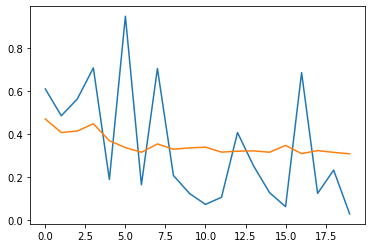

In [228]:
plt.plot(eps,t_loss)
plt.plot(eps,d_loss)
plt.show()

In [248]:
torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))